In [1]:
import pandas as pd
import numpy as np
from custom_ml_toolkit.preprocessor.encoder import SupportMissingDatasetEncoder
from custom_ml_toolkit.feature_selector.importance_explaner import plot_feature_importances, plot_shap_values
from custom_ml_toolkit.eval.classification import classification_reports, create_gain_and_lift_data, plot_lift_curve, plot_gain_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

c:\Users\Nicky\.conda\envs\ml-toolkit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state = 77

data_df = pd.read_csv('example_data/titanic.csv')
data_df['Deck'] = data_df['Cabin'].str[0]

numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
norminal_cols = ['Sex', 'Embarked']
ordinal_cols = ['Pclass', 'Deck']
target_col = 'Survived'

train_data_df, test_data_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=random_state,
    stratify=data_df['Survived']
)

## XGBClassifier

--------------- Train Performance ---------------
              precision    recall  f1-score   support

           0     0.9690    0.9954    0.9820       439
           1     0.9923    0.9487    0.9700       273

    accuracy                         0.9775       712
   macro avg     0.9806    0.9721    0.9760       712
weighted avg     0.9779    0.9775    0.9774       712

--------------- Test Performance ---------------
              precision    recall  f1-score   support

           0     0.8684    0.9000    0.8839       110
           1     0.8308    0.7826    0.8060        69

    accuracy                         0.8547       179
   macro avg     0.8496    0.8413    0.8449       179
weighted avg     0.8539    0.8547    0.8539       179



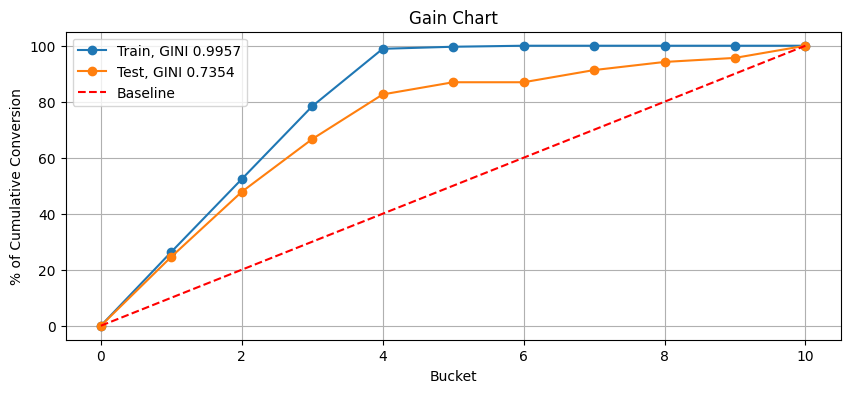

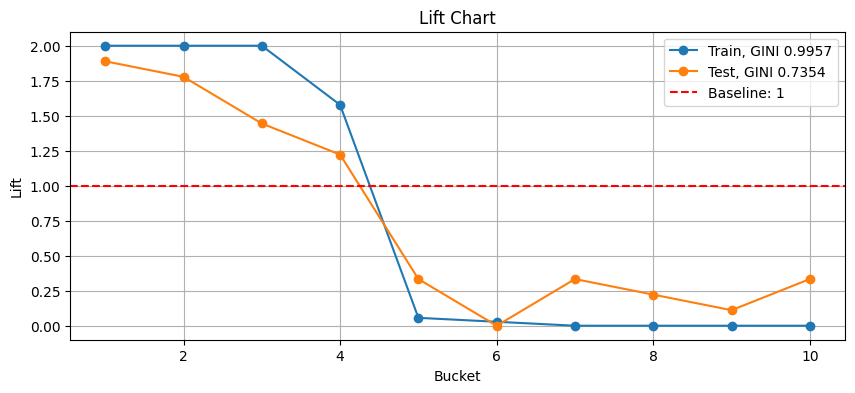

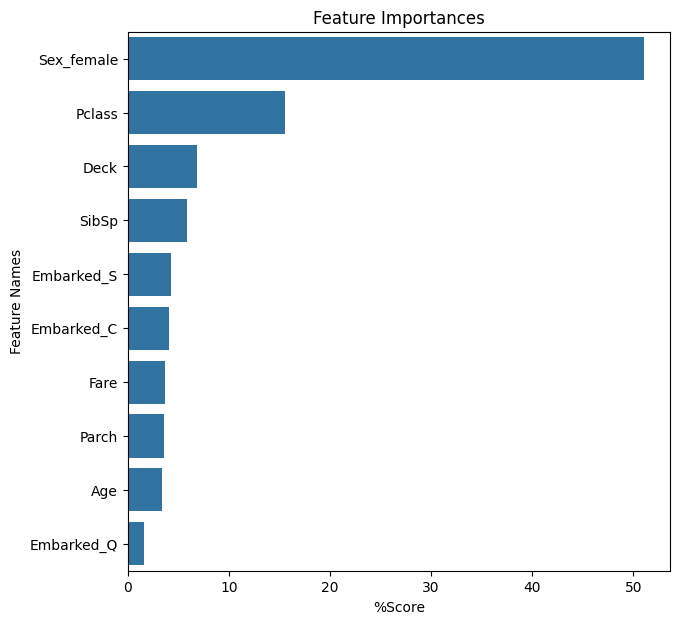

,feature_names,score,%score,cumulative_score
0,Sex_female,0.510846,51.084614,51.084614
1,Pclass,0.155163,15.516347,66.600960
2,Deck,0.068387,6.838736,73.439697
3,SibSp,0.058464,5.846356,79.286057
4,Embarked_S,0.042614,4.261384,83.547440
5,Embarked_C,0.040413,4.041298,87.588737
6,Fare,0.037320,3.732006,91.320747
7,Parch,0.035985,3.598490,94.919235
8,Age,0.034231,3.423148,98.342384
9,Embarked_Q,0.016576,1.657624,100.000008


In [3]:
de = SupportMissingDatasetEncoder(
    numerical_cols=numerical_cols,
    norminal_cols=norminal_cols,
    ordinal_cols=ordinal_cols,
    target_col=target_col,
    drop_binary=True,
    oe_unknown_value=np.nan,
    oe_missing_value=np.nan,
    encode_target=True
)

de.fit(train_data_df)
encoded_train_data_df = de.transform(train_data_df)
encoded_test_data_df = de.transform(test_data_df)

clf = XGBClassifier(
    random_state=random_state,
    n_jobs=-1,
)

X_train = encoded_train_data_df.drop(columns=['Survived'])
y_train = encoded_train_data_df['Survived']

X_test = encoded_test_data_df.drop(columns=['Survived'])
y_test = encoded_test_data_df['Survived']

clf.fit(
    X=X_train,
    y=y_train
)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

y_train_score = clf.predict_proba(X_train)[:,1]
y_test_score = clf.predict_proba(X_test)[:,1]


classification_reports(data={
    'Train': (y_train, y_train_pred),
    'Test': (y_test, y_test_pred)
})

data = {
    'Train': (y_train, y_train_score),
    'Test': (y_test, y_test_score),
}

_ = plot_gain_curve(
    data=data,
    q=10
)

_ = plot_lift_curve(
    data=data,
    # bin_size=100,
    q=10,
    lift=True
)

feat_imp_df = plot_feature_importances(
    feature_importance=clf.feature_importances_,
    feature_names=X_train.columns,
    top_n=30
)

feat_imp_df

In [4]:
# import shap

# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(
#     shap_values=shap_values,
#     features=X_train,
#     plot_type='bar',
#     show=False
# )
# # shap.plots.waterfall(shap_values[3])

# shap_values.shape

## LGBMClassifier

--------------- Train Performance ---------------
              precision    recall  f1-score   support

           0     0.9690    0.9954    0.9820       439
           1     0.9923    0.9487    0.9700       273

    accuracy                         0.9775       712
   macro avg     0.9806    0.9721    0.9760       712
weighted avg     0.9779    0.9775    0.9774       712

--------------- Test Performance ---------------
              precision    recall  f1-score   support

           0     0.8684    0.9000    0.8839       110
           1     0.8308    0.7826    0.8060        69

    accuracy                         0.8547       179
   macro avg     0.8496    0.8413    0.8449       179
weighted avg     0.8539    0.8547    0.8539       179



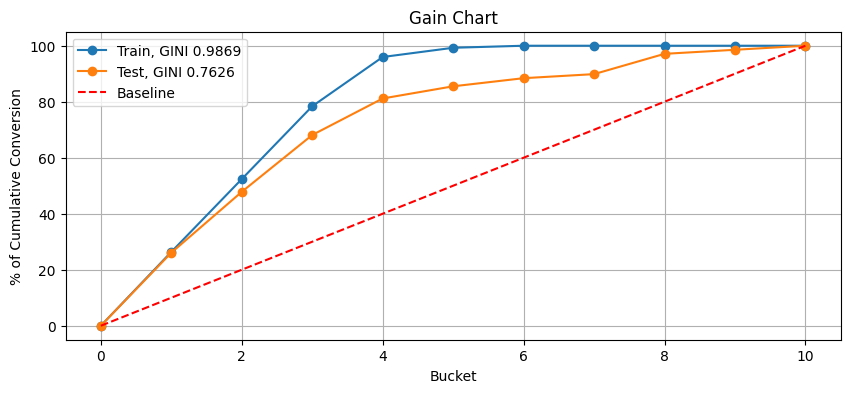

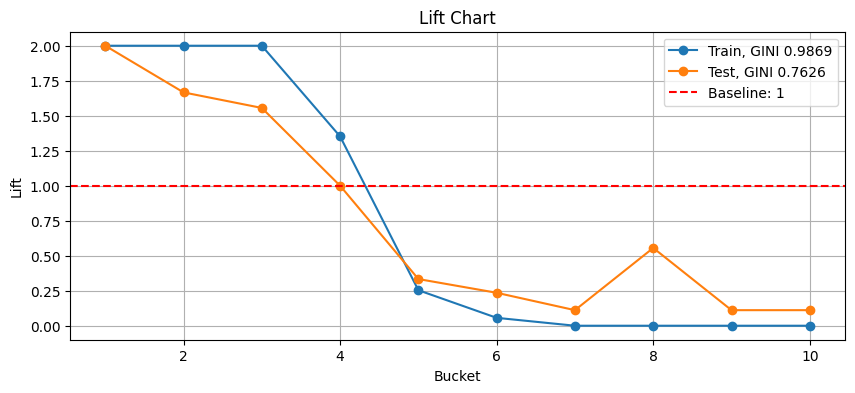

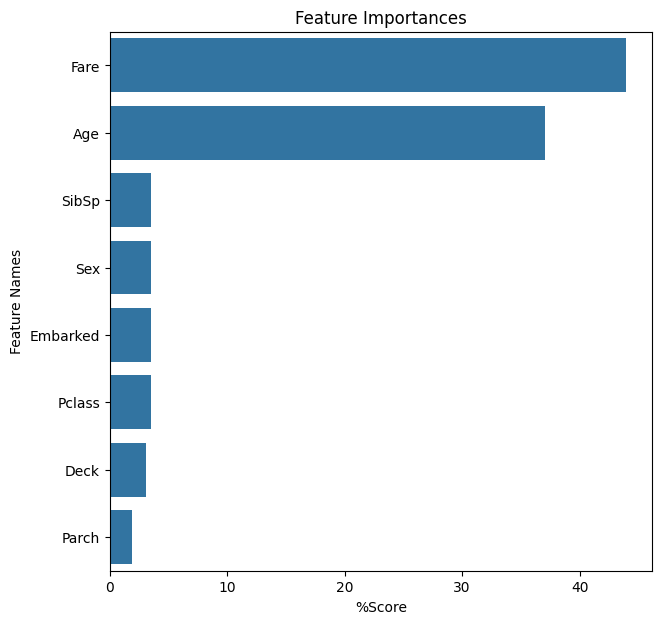

,feature_names,score,%score,cumulative_score
0,Fare,1188,43.983710,43.983710
1,Age,1001,37.060348,81.044058
2,SibSp,95,3.517216,84.561274
3,Sex,95,3.517216,88.078489
4,Embarked,94,3.480193,91.558682
5,Pclass,94,3.480193,95.038874
6,Deck,84,3.109959,98.148834
7,Parch,50,1.851166,100.000000


In [5]:
de = SupportMissingDatasetEncoder(
    numerical_cols=numerical_cols,
    norminal_cols=None,
    ordinal_cols=norminal_cols + ordinal_cols,
    target_col=target_col,
    drop_binary=True,
    oe_unknown_value=-1,
    oe_missing_value=-1,
    encode_target=False
)

de.fit(train_data_df)
encoded_train_data_df = de.transform(train_data_df)
encoded_test_data_df = de.transform(test_data_df)

clf = LGBMClassifier(
    random_state=random_state,
    n_jobs=-1,
    verbose=-1
)

X_train = encoded_train_data_df.drop(columns=['Survived'])
y_train = encoded_train_data_df['Survived']

X_test = encoded_test_data_df.drop(columns=['Survived'])
y_test = encoded_test_data_df['Survived']

clf.fit(
    X=X_train,
    y=y_train,
    categorical_feature=norminal_cols
)

y_train_score = clf.predict_proba(X_train)[:,1]
y_test_score = clf.predict_proba(X_test)[:,1]


classification_reports(data={
    'Train': (y_train, y_train_pred),
    'Test': (y_test, y_test_pred)
})

data = {
    'Train': (y_train, y_train_score),
    'Test': (y_test, y_test_score),
}

_ = plot_gain_curve(
    data=data,
    q=10
)

_ = plot_lift_curve(
    data=data,
    # bin_size=100,
    q=10,
    lift=True
)

feat_imp_df = plot_feature_importances(
    feature_importance=clf.feature_importances_,
    feature_names=X_train.columns,
    top_n=30
)

feat_imp_df

## Overfit DecisionTreeClassifier

In [6]:
de = SupportMissingDatasetEncoder(
    numerical_cols=numerical_cols,
    norminal_cols=norminal_cols,
    ordinal_cols=ordinal_cols,
    target_col=target_col,
    drop_binary=True,
    oe_unknown_value=np.nan,
    oe_missing_value=np.nan,
    encode_target=False
)

de.fit(data_df)
encoded_data_df = de.transform(data_df)

norminal_feature_name_out = de.features_encoder.get_norminal_feature_name_out()
encoded_data_df[numerical_cols + ordinal_cols] = encoded_data_df[numerical_cols + ordinal_cols].fillna(-999)
encoded_data_df[norminal_feature_name_out] = encoded_data_df[norminal_feature_name_out].fillna(0)

clf = DecisionTreeClassifier(
    random_state=random_state,
    # max_depth=15
)

X_train = encoded_data_df.drop(columns=['Survived'])
y_train = encoded_data_df['Survived']

clf.fit(
    X=X_train,
    y=y_train
)

y_train_pred = clf.predict(X_train)

print(classification_report(y_train, y_train_pred))

# plt.figure(figsize=(300,50))
# plt.figure(figsize=(100,50))
# plot_tree(
#     decision_tree=clf,
#     feature_names=X_train.columns,
#     class_names=de.classes_,
#     filled=True,
#     fontsize=6
# )
# plt.savefig(
#     fname ='tree_high_dpi',
#     dpi=100
# )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       549
           1       0.99      0.97      0.98       342

    accuracy                           0.99       891
   macro avg       0.99      0.98      0.99       891
weighted avg       0.99      0.99      0.99       891

